# Modelo Gaussiano Acotado

In [1]:
#from numba import jit, cuda

In [ ]:
from numba import jit, cuda
from timeit import default_timer as timer
import time
import numpy as np
import random
from numpy.random import default_rng
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import torch

In [178]:
pve =  pd.read_csv(r'variograma_experimental_datoscomp.csv')
dc = pd.read_csv(r'datos_completos_palmar_tesis.csv')
matriz_distancias = r'matriz_dist_completos_palmar.csv'
puntosvariogramaexperimental = pd.read_csv(r'variograma_experimental_datoscomp.csv')
vardatos = round(dc['Carga_Hidraulica_c'].std(),2)
dmax = 101096.84
h=np.linspace(0,50549,5000)
sigma_e=np.std(pve.iloc[:,1])

print(vardatos,sigma_e)
e1=0.9 #Variogram
e2=0.05  # Z
e3=0.05 # varianza


distancias =  pd.read_csv('matriz_dist_completos_palmar.csv')
distancias = distancias.to_numpy()
distancias = distancias[:,1:]
indices=[]
indicestotales=np.arange(309)
for i in range(309):
    ind=distancias[i,:]<12110
    indicest=np.where(ind)[0]
    indices.append(np.delete(indicestotales,indicest))
    indices[i]=np.insert(indices[i],1,i)
# [indices.append(i) for i, x in enumerate(indices) if x]
dc =  dc.to_numpy()   
dc=dc[:,-1]
Z = dc
Z = Z.reshape(len(Z),1)
ZA = np.zeros((len(Z),1))
Ve = np.zeros((len (Z),1))

119.33 5272.038947200616


In [179]:
# @jit(target_backend='cuda')
def calculo_z(distancias,indices,dc,Z,ZA,Ve,h,co,s,a):         
    i = 0   
    while(i<len(distancias)):
        gamma=distancias[:,i]
        gamma= np.delete(gamma,indices[i],axis=0)
        matriz_reducida = np.delete(distancias,indices[i],axis=0)
        matriz_reducida = np.delete(matriz_reducida,indices[i],axis=1)
        sz=matriz_reducida.shape[0]
        matriz_reducida = co + s*(1-np.exp(-(matriz_reducida**2/a**2)))
        matriz_reducida = np.concatenate((matriz_reducida, np.ones((1,sz))), axis = 0)
        matriz_reducida = np.concatenate((matriz_reducida, np.ones((sz+1,1))), axis = 1)
        matriz_reducida[-1,-1]=0
        matriz_reducida[matriz_reducida > s] = s
        gamma_l = co + s*(1-np.exp(-(gamma**2/a**2))) 
        gamma_l[gamma_l > s] = s
        gamma = np.c_[gamma_l.reshape(1,sz), 1]
        gamma = gamma.T 
        matriz_reducida = matriz_reducida - np.diag(matriz_reducida) * np.identity(matriz_reducida.shape[0])
        M=torch.from_numpy( matriz_reducida)
        G=torch.from_numpy(gamma)
        Lamda=torch.linalg.solve(M,G)
        # A = np.linalg.inv(matriz_reducida)
        # Lamda = np.matmul(A,gamma)
        
        z= np.delete(dc,indices[i],axis=0)
        # z= torch.from_numpy(z.astype(float))
        b=gamma.T
        # bt = torch.from_numpy(gamma.T)
        vee = np.matmul(b,Lamda)
        # vee= torch.matmul(bt,Lamda)    
        Ve[i]=vee
        Lamda=Lamda[:-1,:]
        Za=np.dot(z,Lamda)
        # Za=torch.matmul(z,LamdA[:-1])
        ZA[i]= Za
        i=i+1       
    error = np.sqrt(1/len(Z)*np.sum((Z-ZA)**2)) 
    error_3 =(1/len(Z))*np.sum(((Z-ZA)**2)/Ve)
    return (error,error_3)  

In [180]:
def initial_population(size_population,nbits,num_var, verbose=False): 
    """ size_population  = tamaño de la población
       nbists = número de bits de la cadena DNA
    """
    individuos=np.zeros((size_population,nbits,num_var))
    for i in range(size_population):
        for j in range(num_var):
            individuos[i,:,j] = [(random.getrandbits(1)) for number in range(1, nbits+1)]
            if verbose:
                print("Individuo " +str(i+1)+ " variable "+str(j) + ":  " + str(individuos[i,:,j]))     
    return (individuos)

In [181]:
def binatodeci(binary):
    salida=sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))
    return salida

In [182]:
def fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var,verbose=False): 
    """ fx        = función a optimizar
       Individuos = población a evaluar
       interval   = [max y min]
    """
    fitness_population=np.zeros((size_population,)) 
    fitness_prob=np.zeros((size_population,)) 
    max_value=(2**nbits-1)
    mini_e=[]
    for i in range(size_population):
        x=np.zeros((num_var,))
        
        x[1]=binatodeci(individuos[i,:,1])
        x[1]= ((vardatos-0)*x[1])/max_value
        x[0]= binatodeci(individuos[i,:,0])
        x[0]= ((x[1]-0)*x[0])/max_value
        x[2]=binatodeci(individuos[i,:,2])
        x[2]= (((dmax/2)-0)*x[2])/max_value
        #x[3]= binatodeci(individuos[i,:,3])
        #x[3]= x[3]/max_value
        #x[4]= binatodeci(individuos[i,:,4])
        #x[4] = ((0.2-(0.6*x[3]))/max_value)

        est_lag=x[0] + x[1]*(1-np.exp(-(pve.iloc[:,0]**2/x[2]**2)))
        error_variogram=np.sqrt(1/len(est_lag)*np.sum((est_lag-pve.iloc[:,1])**2))
        error_z,error_variance = calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])
        error_variance=np.sqrt(np.abs(1-error_variance))
        # error_variogram=Error(pve.iloc[:,1],svar(pve.iloc[:,0],x[0],x[1],x[2]))
        mini_e.append(error_z)
        # print(np.c_[error_variogram/sigma_e, error_z/vardatos,error_variance])
        #fitness_population[i]=(x[3]*Error(pve.iloc[:,1],svar(pve.iloc[:,0],x[0],x[1],x[2]))) + ((x[4])*(error_2[0])) + ((1-x[3]-x[4])*(np.abs(1-error_2[1])))
        fitness_population[i]=(e1*error_variogram/sigma_e) + (e2*error_z/vardatos) + (e3*error_variance)
        if verbose:
            print("\n")
            print("Individuo " +str(i+1) +":  " + "   f(x)="+ str(fitness_population[i]))
            print("Pepita: " +str(x[0]))
            print("Meseta: " +str(x[1]))
            print("Alcance: " +str(x[2]))
        
    mini=np.amin(fitness_population)
    ind_mini=np.argmin(fitness_population)
    thebest_individuo=individuos[ind_mini,:,:]
    if verbose:
        print("el mejor individuo: " +str(ind_mini+1))
        
    return fitness_population, thebest_individuo , mini_e

In [183]:
def selection(fitness_population, individuos,size_population,num_var,selection_method="tournament",verbose=False): 
    """ fitness_population  = Evalaución de la población
       fitness_prob = Evalaución de la población inversa y normalizada  
       metodo_seleccion="tournament"
    """
    selected_population=np.zeros((size_population,nbits,num_var))
    if selection_method == "tournament":
        ind_tournament= [random.randint(0, size_population-1) for i in range(size_population)]
        for i,j in zip(range(size_population),ind_tournament):
            mini= np.argmin([ fitness_population[i],fitness_population[j]])
            if mini==0:
                selected_population[i,:,:]=individuos[i,:,:]
                sel=i
            else:
                selected_population[i,:,:]=individuos[j,:,:]
                sel=j
            if verbose:
                [print("Individuo seleccionado var "+ str(ii)+" : " + str(selected_population[i,:,ii])) for ii in range(num_var)]

                # print("Individuo seleccionado:" +str(np.transpose(selected_population[i,:,:])))    
    return selected_population

In [184]:
def crossover(selected_population, individuos,size_population,nbits,num_var,verbose=False): 
    """ fitness_population  = Evalaución de la población
       fitness_prob = Evalaución de la población inversa y normalizada  
       metodo_seleccion="tournament"
    """
    pointC= [random.randint(1, nbits-2) for i in range(size_population)]
   
    # [print(selected_population[i]) for i in range(size_population)]
    i=0
    cont_int=0
    new_generation=np.zeros((size_population,nbits,num_var))
    rng = default_rng()
    ind_parents=np.zeros((num_var,2))
    parents= np.zeros((2,num_var,nbits))
    for j in range(num_var):
        ind_parents[j,:] = rng.choice(size_population, size=2, replace=False)
        parents[0,j,:]=selected_population[int(ind_parents[j,0]),:,j]
        parents[1,j,:]=selected_population[int(ind_parents[j,1]),:,j]
    for i in range(size_population):
        for j in range(num_var):
            new_generation[i,:,j] =np.concatenate((parents[0,j,0:pointC[i]],parents[1,j,pointC[i]:]))

    if verbose:
        [print("Individuo " + str(i+1)+" seleccionado var: "+ str(ii)+"  " + str(new_generation[i,:,ii])) for ii in range(num_var)]
    i += 1
    
    individuos=new_generation
    
    return individuos

In [185]:
def mutation(individuos,size_population,nbits,num_var, prob_mut=0.02, verbose=False): 
    """ prob  = probabilidad de mutación debe ser baja
    """
    # [print(individuos[ii]) for ii in range(size_population)]
    dat=np.random.uniform(low=0,high=1,size=(size_population,nbits,num_var))<prob_mut
    x,y,z=np.where(dat)
    n_mut= len(x)
    for i,j,k in zip(x,y,z):
        individuos[i,j,k]=1-individuos[i,j,k]
            
    if verbose:
        print("numbers of mutated bits: " + str(n_mut))
    return individuos

In [186]:
size_population=16
nbits=12
individuos=initial_population(size_population,nbits,num_var=3,verbose=False)
history=[]
history_z=[]
start = time.perf_counter()

for ite in range(10):
    fitness_population,thebest_individuo,err_z=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=3,verbose=False)
    ind_mini=np.argmin(fitness_population)
    history.append(fitness_population[ind_mini])
    history_z.append(err_z[ind_mini])
    selected_population=selection(fitness_population, individuos,size_population,num_var=3,selection_method="tournament",verbose=False)
    individuos=crossover(selected_population, individuos,size_population,nbits,num_var=3,verbose=False)
    individuos=mutation(individuos,size_population,nbits,num_var=3, prob_mut=0.02, verbose=False)
    individuos[0,:,:]=thebest_individuo
    print('iteracion: %5.0f'%ite)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))
fitness_population,thebest_individuo,err_z=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=3,verbose=False)
ind_mini=np.argmin(fitness_population)
max_value=(2**nbits-1)
history1=history
history_z1=history
x=np.zeros((3,))
x[1]=binatodeci(individuos[ind_mini,:,1])
x[1]= ((vardatos-0)*x[1])/max_value
x[0]= binatodeci(individuos[ind_mini,:,0])
x[0]= ((x[1]-0)*x[0])/max_value
x[2]=binatodeci(individuos[ind_mini,:,2])
x[2]= (((dmax/2)-0)*x[2])/max_value
xr=x
est_lag=x[0] + x[1]*(1-np.exp(-(pve.iloc[:,0]**2/x[2]**2)))
error_variogram=np.sqrt(1/len(est_lag)*np.sum((est_lag-pve.iloc[:,1])**2))
error_z,error_variance = calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])
print(error_variogram,error_z,error_variance)

iteracion:     0
iteracion:     1
iteracion:     2
iteracion:     3
iteracion:     4
iteracion:     5
iteracion:     6
iteracion:     7
iteracion:     8
iteracion:     9
Elapsed (with compilation) = 21.829807099999925s
10014.150446731146 32.555725402019185 9.341773194405897


In [ ]:
start = time.perf_counter()

for ite in range(100):
    fitness_population,thebest_individuo,err_z=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=3,verbose=False)
    ind_mini=np.argmin(fitness_population)
    history.append(fitness_population[ind_mini])
    history_z.append(err_z[ind_mini])
    selected_population=selection(fitness_population, individuos,size_population,num_var=3,selection_method="tournament",verbose=False)
    individuos=crossover(selected_population, individuos,size_population,nbits,num_var=3,verbose=False)
    individuos=mutation(individuos,size_population,nbits,num_var=3, prob_mut=0.02, verbose=False)
    individuos[0,:,:]=thebest_individuo
    print('iteracion: %5.0f'%ite)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))
fitness_population,thebest_individuo,err_z=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=3,verbose=False)
ind_mini=np.argmin(fitness_population)

max_value=(2**nbits-1)
x=np.zeros((3,))
x[1]=binatodeci(individuos[ind_mini,:,1])
x[1]= ((vardatos-0)*x[1])/max_value
x[0]= binatodeci(individuos[ind_mini,:,0])
x[0]= ((x[1]-0)*x[0])/max_value
x[2]=binatodeci(individuos[ind_mini,:,2])
x[2]= (((dmax/2)-0)*x[2])/max_value
#x[3]= binatodeci(individuos[ind_mini,:,3])
#x[3]= x[3]/max_value
#x[4]= binatodeci(individuos[ind_mini,:,4])
#x[4] = ((0.2-(0.6*x[3]))/max_value)
print(x)
est_lag=x[0] + x[1]*(1-np.exp(-(pve.iloc[:,0]**2/x[2]**2)))
error_variogram=np.sqrt(1/len(est_lag)*np.sum((est_lag-pve.iloc[:,1])**2))
error_z,error_variance = calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])
print(error_variogram,error_z,error_variance)

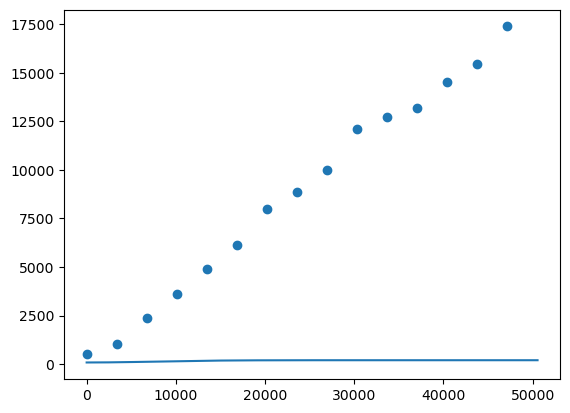

[0.00000000e+00 1.01118224e+01 2.02236447e+01 ... 5.05287764e+04
 5.05388882e+04 5.05490000e+04]
100283209.16976562


In [187]:
h=np.linspace(0,50549,5000)
b=  x[0] + x[1]*(1-np.exp(-(h**2/x[2]**2)))
plt.scatter(pve.iloc[:,0],pve.iloc[:,1])
plt.plot(h,b)
plt.show()
print(h)
me= x[0] + x[1]*(1-np.exp(-(pve.iloc[:,0]**2/x[2]**2)))
svar = pve.iloc[:,1]
error = 1/len(svar)*np.sum((svar-me)**2)
print(error)

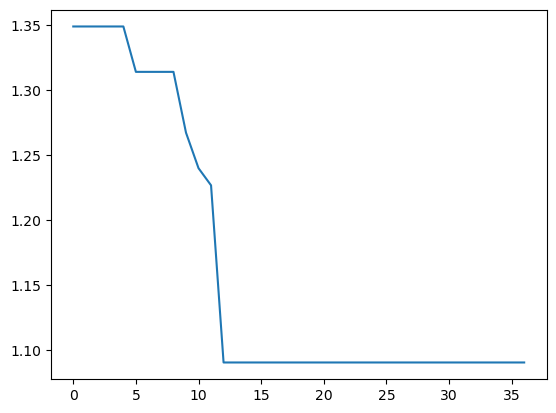

In [73]:
plt.plot(history)

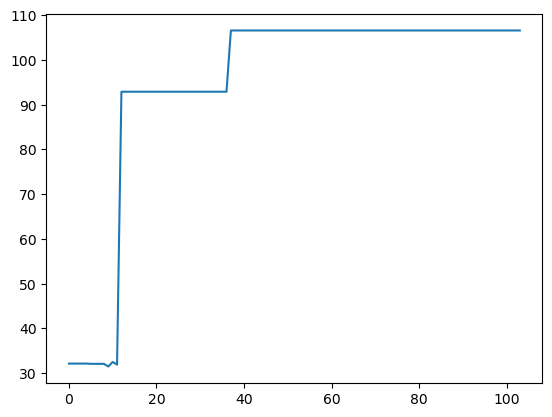

In [74]:
plt.plot(history_z)

In [35]:
max_value=(2**nbits-1)

In [36]:
history1=history
history_z1=history
x=np.zeros((3,))
x[1]=binatodeci(individuos[ind_mini,:,1])
x[1]= ((vardatos-0)*x[1])/max_value
x[0]= binatodeci(individuos[ind_mini,:,0])
x[0]= ((x[1]-0)*x[0])/max_value
x[2]=binatodeci(individuos[ind_mini,:,2])
x[2]= (((dmax/2)-0)*x[2])/max_value
xr=x

In [140]:
print(xr)

[  62.48699836   97.59125031 3382.23860317]
